In [1]:
from tensorflow.keras.models import load_model
from PIL import Image
import numpy as np
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import json

In [2]:
# Load the saved ResNet50 model file
resnet50_loaded_model = load_model('resnet50_plant_identification_model.h5')

In [8]:
# Display the loaded model's summary
resnet50_loaded_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,648,088 (94.02 MB)

 Trainable params: 1,060,374 (4.05 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 2 (12.00 B)

In [3]:
# Load the class indices
with open('class_indices.json', 'r') as f:
    class_indices = json.load(f)
class_indices = {int(k): v for k, v in class_indices.items()}

In [4]:
# Function to preprocess and predict
def predict_image_class_with_probabilities(model, image_path, class_indices):
    def load_and_preprocess_image(image_path, target_size=(224, 224)):
        img = Image.open(image_path).resize(target_size)
        img_array = np.array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)
        return img_array

    # Preprocess the image
    preprocessed_img = load_and_preprocess_image(image_path)

    # Predict probabilities
    predictions = model.predict(preprocessed_img)

    # Get class probabilities and predicted class
    class_probabilities = {class_name: round(prob * 100, 2) for class_name, prob in zip(class_indices.values(), predictions[0])}
    predicted_class_index = np.argmax(predictions[0])
    predicted_class_name = class_indices[predicted_class_index]
    predicted_class_prob = class_probabilities[predicted_class_name]

    return predicted_class_name, predicted_class_prob, class_probabilities

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step


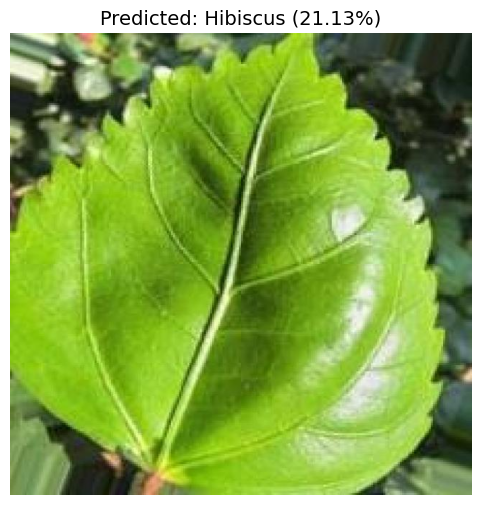

In [6]:
# Path to the image
image_path = '/Users/aniketanilpalse/Downloads/Vishwakarma_University_(VU) /Sem-VI/Z_(Hackaton, Mega Project)/02_Mega_Project/Z_Dataset/Plant Identification/test/Hibiscus/aug_0_6809_jpg.rf.02f115e1471eab113ff650cfd7851266.jpg' 

# Predict using the loaded ResNet50 model
predicted_class_name, predicted_class_prob, class_probabilities = predict_image_class_with_probabilities(
    resnet50_loaded_model, image_path, class_indices
)

# Display results
img = mpimg.imread(image_path)
plt.figure(figsize=(6, 6))
plt.imshow(img)
plt.axis('off')
plt.title(f"Predicted: {predicted_class_name} ({predicted_class_prob}%)", fontsize=14)
plt.show()

In [7]:
# Print class probabilities
print("Class Probabilities:")
for class_name, prob in sorted(class_probabilities.items()):
    print(f"{class_name}: {prob:.2f}%")

Class Probabilities:
Adulsa: 3.54%
Alovera: 0.62%
Amla: 1.24%
Banana: 2.73%
Beetal Leaf (Pan): 11.97%
Bramhi: 13.79%
Curry Leaves: 3.42%
Drumstick: 3.18%
Eranda: 1.44%
Gokarna: 5.04%
Hibiscus: 21.13%
Jamun (Indian Blackberry): 4.74%
Mango: 7.30%
Neem: 2.45%
Onion: 0.17%
Panfuti: 7.83%
Papaya: 1.16%
Satynashi: 0.30%
Shatavari: 0.69%
Sugarcane: 0.10%
Tandulja: 0.21%
Touch Me Not: 6.95%
